# Uncovering the Liars in the Political Scene of America

This notebook will present a data analysis task on the "Liar, Liar Pants on Fire" dataset, available for download [here](https://www.cs.ucsb.edu/˜william/data/liar_dataset.zip), in the framework of a project for the class "Applied Data Analysis" at EPFL. More precisely, it will first present the work done for milestone 2 and a plan up until milestone 3 and then in a second section the work done for milestone 3.

### Table of contents:
* [Milestone 2](#milestone-2)
    * [Loading phase](#loading-phase)
    * [Cleaning phase](#cleaning-phase)
    * [Loading additional files](#loading-additional-files)
    * [Data analysis](#data-analysis)
        * [Bar chart](#bar-chart)
        * [Relative importance of each feature](#relative-importance)
        * [Map visualization](#map-visualization)
    * [Plan for milestone 3](#plan-ms-3)
* [Milestone 3](#milestone-3)
    * [Natural Language Processing](#nlp)
        * [NLTK](#nltk)
        * [RAKE](#rake)
    * [Pie charts](#pie-charts)
    * [Word Cloud](#word-cloud)
    * [Venn diagram](#venn-diagram)
    * [NetworkX](#pie-charts)
    * [Holoviews circle](#holoviews)
    * [Sentiment analysis](#sentiment)
        * [Democrats](#sentiment-democrat)
        * [Republicans](#sentiment-republican)

In [1]:
# Imports
import pandas as pd
import numpy as np
import json
import folium
import os
import codecs
import string
import ipywidgets as ipw
import html
import matplotlib.pyplot as plt
import rake_nltk
import pygal
import base64
import branca.colormap as cm
import networkx as nx
import collections
import itertools
import warnings
import holoviews as hv
import nltk
import spacy
import vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from rake_nltk import Rake
from operator import itemgetter
from networkx.algorithms import bipartite
from matplotlib_venn_wordcloud import venn2_wordcloud
from ipywidgets import HTML
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman

% matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

## Milestone 2 <a class="anchor" id="milestone-2"></a>

In this section, you can find all the work which was done between milestone 1 and 2.

* [Loading phase](#loading-phase)
* [Cleaning phase](#cleaning-phase)
* [Loading additional files](#loading-additional-files)
* [Data analysis](#data-analysis)
    * [Bar chart](#bar-chart)
    * [Relative importance of each feature](#relative-importance)
    * [Map visualization](#map-visualization)
* [Plan for milestone 3](#plan-ms-3)

### Loading phase <a class="anchor" id="loading-phase"></a>

The liar dataset is composed of three different datasets, namely `test.tsv`, `train.tsv` and `valid.tsv`, which we first load into Pandas dataframes with corresponding names. All of these datasets have exactly the same schema. The purpose of having three different datasets is to do machine learning, which is not the goal of this project. In consequence, we will combine all three dataframes `test`, `train` and `valid` into a single one, `liar`.

The schema of these datasets is outlined below. There is a total of 14 columns and each row refers to a statement.

> Column 1: ID of the statement ([ID].json).
> 
> Column 2: Label.
> 
> Column 3: Statement.
> 
> Column 4: Subject(s).
> 
> Column 5: Speaker.
> 
> Column 6: Speaker's job title.
> 
> Column 7: State info.
> 
> Column 8: Party affiliation.
> 
> Column 9: Barely true counts.
> 
> Column 10: False counts.
> 
> Column 11: Half true counts.
> 
> Column 12: Mostly true counts.
> 
> Column 13: Pants on fire counts.
> 
> Column 14: Context (venue / location of the speech or statement).

In order to reduce the size of the dataframe, we could drop the columns which we do not need. Note that this is not required because the dataset is rather small, but could be done simply for the sake of convenience. However, we will probably need all columns, so no action will be taken there.

In [2]:
DATA_DIR = 'data/'
SCHEMA = ['statement_id', 'label', 'statement', 'subject', 
          'speaker', 'profession', 'state', 'party', 
          'barely_true', 'false', 'half_true', 
          'mostly_true', 'pants_on_fire', 'context']

# Load the datasets into pandas dataframes
test = pd.read_csv(DATA_DIR + 'test.tsv', delimiter='\t', header=None, names=SCHEMA, index_col=False)
train = pd.read_csv(DATA_DIR + 'train.tsv', delimiter='\t', header=None, names=SCHEMA, index_col=False)
valid = pd.read_csv(DATA_DIR + 'valid.tsv', delimiter='\t', header=None, names=SCHEMA, index_col=False)


# Combine the three dataframes into one
liar = pd.concat([train, test, valid], ignore_index=True)

In [3]:
# Display the dataframe
liar.head(3)

statement_id        label  \
0    2635.json        false   
1   10540.json    half-true   
2     324.json  mostly-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   

                              subject         speaker            profession  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   

      state       party  barely_true  false  half_true  mostly_true  \
0     Texas  republican          0.0    1.0        0.0          0.0   
1  Virginia    democrat          0.0    0.0        1.0          1.0   
2  Illinois    democrat         70.0   71.0      160.0        163.0   

   pants_on_fire          context  
0            0.0         a mailer  
1            0.0  a floor speech.  
2            9.0           Denver

We can check that the three datasets are different (which they should based on their purpose):

In [4]:
liar['statement_id'].is_unique

True

### Cleaning phase <a class="anchor" id="cleaning-phase"></a>

This dataset id very clean by nature because it is not just a collection of data. Indeed, it was intended for use by other data scientists as a benchmark dataset and it will therefore not need many data cleaning operations. We can start by checking if every row is complete or if there are any NaNs or missing values.

In [5]:
liar.isna().any()

statement_id     False
label            False
statement        False
subject           True
speaker           True
profession        True
state             True
party             True
barely_true       True
false             True
half_true         True
mostly_true       True
pants_on_fire     True
context           True
dtype: bool

It appears that most of the columns, more precisely column 4 to 15, do have missing values. However, we will not drop every row where there are NaNs because the other fields in these rows might still be useful.

We will now investigate how the data is formatted to check for potential inconcistencies. We can start with the column concerning the state where the statement was made, because we can have a fairly good idea of what it should contain (i.e. names of locations like states or countries).

In [6]:
liar.state.unique()

array(['Texas', 'Virginia', 'Illinois', nan, 'Florida', 'Wisconsin',
       'New Jersey', 'Vermont', 'Massachusetts', 'Maryland',
       'Washington, D.C. ', 'Oregon', 'New York', 'Washington, D.C.',
       'California', 'Missouri', 'Rhode Island', 'West Virginia',
       'Arkansas', 'New Hampshire', 'Ohio', 'Georgia', 'Arizona',
       'Wyoming', 'Delaware', 'Kentucky', 'Kansas', 'ohio', 'Colorado',
       'North Carolina', 'New Mexico', 'Illinois ', 'Alaska',
       'South Carolina', 'Minnesota', 'Tennessee', 'Pennsylvania', 'Iowa',
       'Connecticut', 'Louisiana', 'Indiana', 'Florida ', 'Utah',
       'Michigan', 'Oklahoma', 'Nevada', 'Oregon ', 'Virgina', 'Nebraska',
       'Georgia ', 'None', 'Washington D.C.', 'California ',
       'Massachusetts ', 'Alabama', 'Russia', 'Washington state',
       'Washington', 'District of Columbia', 'Unknown', 'Colorado ',
       'New Hampshire ', 'Mississippi', 'Rhode island', 'China',
       'United Kingdom', 'Virginia ', 'South Dakota', 'Qa

As we can see, there are inconcistencies in the use of upper case (e.g. `Ohio` and `ohio`) and problems with trailing spaces (e.g. `Georgia` and `Georgia  `). We can take care of these issues by making everything lower case and removing leading and trailing spaces.

In [7]:
def clean(s):
    '''
    Replaces upper case letters by lower case ones and removes leading and trailing spaces.
    :param s: str
    :return: s
    '''
    if isinstance(s, str):
        s = s.lower()\
             .strip()
    return s

In [8]:
# Number of rows before dropping "all Nans" rows
print('Number of unique entities in "state" before applying "clean": %s'%liar.state.unique().shape[0])

liar['state'] = liar['state'].apply(clean)

# Number of rows before dropping "all Nans" rows
print('Number of unique entities in "state" after  applying "clean": %s'%liar.state.unique().shape[0])

Number of unique entities in "state" before applying "clean": 86
Number of unique entities in "state" after  applying "clean": 70


Note that there are still other issues with the data, but we will not take care of them. For example, there are spelling mistakes (e.g. `virgiia` instead of `virginia`). We will ignore them because we can assume that these spelling mistakes will concern only one statement, which means it is not worth taking the time to take care of that kind of issues.

In order to clean the other columns in liar, we will use the same function as above, `clean`. We can indeed assume that they might suffer from the same inconsistencies. It is important to point out that we will not touch to the column `statement` because we want to keep all statements as they were originally written. If we were to modify them, then all conclusions from the analysis of the statements themselves would loose credibility.

In [9]:
for col_name in liar.columns:
    if not (col_name == 'statement'):
        liar[col_name] = liar[col_name].apply(clean)

We can now take a final look at our cleaned `liar` dataframe.

In [10]:
# Display the dataframe
liar.head(3)

statement_id        label  \
0    2635.json        false   
1   10540.json    half-true   
2     324.json  mostly-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   

                              subject         speaker            profession  \
0                            abortion    dwayne-bohac  state representative   
1  energy,history,job-accomplishments  scott-surovell        state delegate   
2                      foreign-policy    barack-obama             president   

      state       party  barely_true  false  half_true  mostly_true  \
0     texas  republican          0.0    1.0        0.0          0.0   
1  virginia    democrat          0.0    0.0        1.0          1.0   
2  illinois    democrat         70.0   71.0      160.0        163.0   

   pants_on_fire          context  
0            0.0         a mailer  
1            0.0  a floor speech.  
2            9.0           denver

### Loading additional files <a class="anchor" id="loading-additional-files"></a>

In order to create maps using folium displaying content from the `liar` dataframe, a new column with the abbreviations of the states will be added. The pairs state name/abbreviations are all contained in the file `states_abbreviation.csv`, which can be downloaded [here](http://www.fonz.net/blog/archives/2008/04/06/csv-of-states-and-state-abbreviations/).

In [11]:
# load the file 'states_abbreviation.csv' into a dataframe
states_abbreviation = pd.read_csv(DATA_DIR + 'states_abbreviation.csv')

# Make sure we have the same format than in liar
states_abbreviation['State'] = states_abbreviation['State'].apply(clean)

i = 0
for state_name in liar['state']:
    temp = states_abbreviation.Abbreviation[state_name==states_abbreviation.State].values
    if temp.size != 0:
        liar.at[i, 'state_abbreviation'] = temp[0]
    else:
        liar.at[i, 'state_abbreviation'] = np.nan
    i+=1

In [12]:
# Display the dataframe
liar.head(3)

statement_id        label  \
0    2635.json        false   
1   10540.json    half-true   
2     324.json  mostly-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   

                              subject         speaker            profession  \
0                            abortion    dwayne-bohac  state representative   
1  energy,history,job-accomplishments  scott-surovell        state delegate   
2                      foreign-policy    barack-obama             president   

      state       party  barely_true  false  half_true  mostly_true  \
0     texas  republican          0.0    1.0        0.0          0.0   
1  virginia    democrat          0.0    0.0        1.0          1.0   
2  illinois    democrat         70.0   71.0      160.0        163.0   

   pants_on_fire          context state_abbreviation  
0            0.0         a mailer                 TX  
1            0.0  a floor speech.                 VA  
2            9.0           denver                 IL

Finally, we will also load two additional datasets, `pop-urban-pct-historical.xls` and `federalelections2016.xlsx`, which will have the purpose of highlighting potential explanations for the distribution of fake news across America. They are available for download respectively [there](https://www.icip.iastate.edu/tables/population/urban-pct-states) and [there](https://transition.fec.gov/pubrec/electionresults.shtml). For the same reason as earlier, we will add a column with the abbreviations of the states.

In [13]:
# Load pop-urban-pct-historical.xls
states_urban = pd.read_excel(DATA_DIR + 'pop-urban-pct-historical.xls', sheet_name='States',
                             header=5, usecols='B:G,I:M,O:P')
states_urban = states_urban[1:52]

# Make sure we have the same format than in states_abbreviation
states_urban['Area Name'] = states_urban['Area Name'].apply(clean)

# Add the states abbreviations
i = 1
for state_name in states_urban['Area Name']:
    temp = states_abbreviation.Abbreviation[state_name==states_abbreviation.State].values
    if temp.size != 0:
        states_urban.at[i, 'state_abbreviation'] = temp[0]
    else:
        states_urban.at[i, 'state_abbreviation'] = np.nan
    i+=1

In [14]:
# Display the dataframe
states_urban.head(3)

Area Name  1900  1910  1920  1930  1940  1950  1960  1970  1980  1990  2000  \
1   alabama  11.9  17.3  21.7  28.1  30.2  43.8  54.8  58.6  60.0  60.4  55.4   
2    alaska  24.5   9.5   5.6  13.2  24.0  26.6  37.9  56.9  64.3  67.5  65.6   
3   arizona  15.9  31.0  36.1  34.4  34.8  55.5  74.5  79.6  83.8  87.5  88.2   

   2010 state_abbreviation  
1  59.0                 AL  
2  66.0                 AK  
3  89.8                 AZ

In [15]:
# Load federalelections2016.xlsx
states_election = pd.read_excel(DATA_DIR + 'federalelections2016.xlsx', sheet_name=15,
                                header=6, usecols='A:B,E,H,K,N,Q')
states_election = states_election[1:52]
states_election = states_election.rename(columns={"CLINTON": 2016, "OBAMA": 2012,
                                                  "OBAMA.1": 2008, "KERRY": 2004,
                                                  "GORE": 2000, "CLINTON.1": 1996})

# Make sure we have the same format than in states_abbreviation
states_election['STATE'] = states_election['STATE'].apply(clean)

# Add the states abbreviations
i = 1
for state_name in states_election['STATE']:
    temp = states_abbreviation.Abbreviation[state_name==states_abbreviation.State].values
    if temp.size != 0:
        states_election.at[i, 'state_abbreviation'] = temp[0]
    else:
        states_election.at[i, 'state_abbreviation'] = np.nan
    i+=1

In [16]:
# Display the dataframe
states_election.head(3)

STATE      2016      2012    2008    2004   2000   1996  \
1  alabama  0.343579   0.38359  0.3874  0.3684  41.57  43.16   
2   alaska  0.365509  0.408127  0.3789  0.3552  27.67  33.27   
3  arizona   0.45126  0.445898  0.4512   0.444  44.73  46.52   

  state_abbreviation  
1                 AL  
2                 AK  
3                 AZ

### Data analysis <a class="anchor" id="data-analysis"></a>

After the initialization with the loading and cleaning phases, we can start the data anlysis _per se_. First, we will create a simple bar chart showing the number of statements made in each states. Then, we will create a visualization tool to understand which feature plays an important role. Finally, we will look at the geographical distribution of fake news and try to correlate it with additional data.

#### Bar chart <a class="anchor" id="bar-chart"></a>

The goal here is to get a first idea of how many statements were made in each states. For that, we will make a stacked bar chart showing the number of statements for every label and for each states. Note that we will consider here only american states.

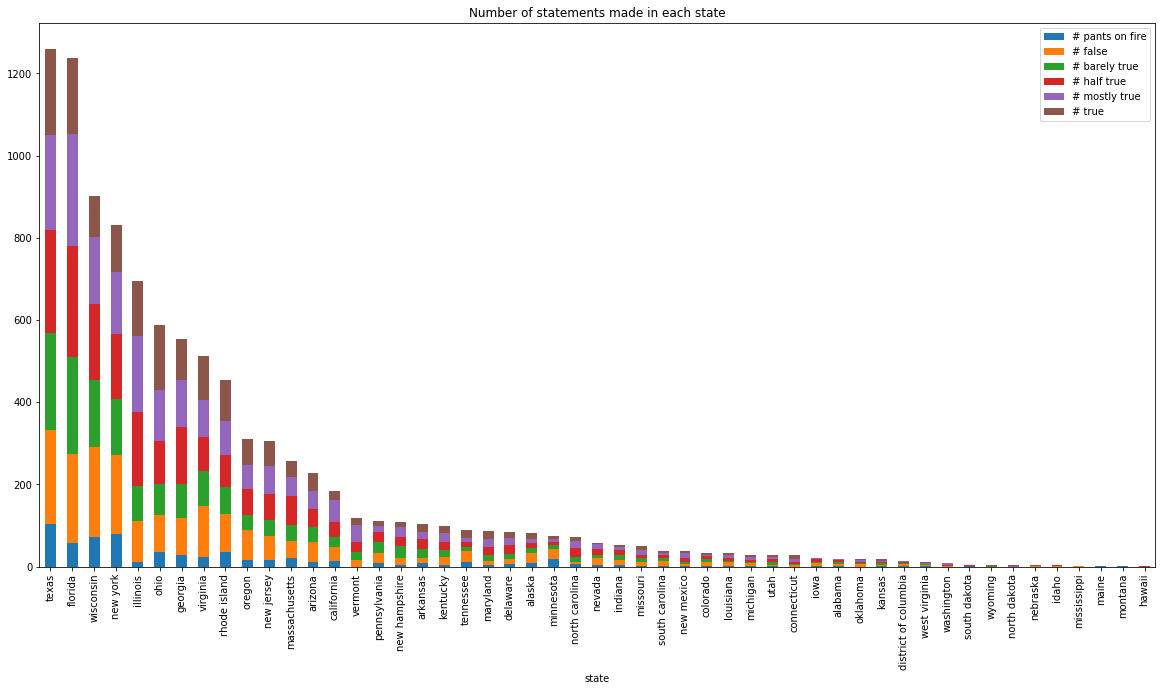

In [17]:
# Get a dataframe with the number of statements for each state and for each label
state_count = liar.dropna(subset=['state_abbreviation'])\
                  .groupby(['state','label'])\
                  .count()\
                  .reset_index()\
                  .filter(['state', 'label', 'statement_id'])\
                  .rename(columns={'statement_id':'#'})

# Get a dataframe for each label with the number of statements for each state
df_total       = liar.dropna(subset=['state_abbreviation']).groupby('state').count().filter(['statement_id']).rename(columns={'statement_id':'#_total'})
df_pants_fire  = state_count[state_count['label']=='pants-fire'] .drop('label', axis=1).set_index('state')
df_false       = state_count[state_count['label']=='false']      .drop('label', axis=1).set_index('state')
df_barely_true = state_count[state_count['label']=='barely-true'].drop('label', axis=1).set_index('state')
df_half_true   = state_count[state_count['label']=='half-true']  .drop('label', axis=1).set_index('state')
df_mostly_true = state_count[state_count['label']=='mostly-true'].drop('label', axis=1).set_index('state')
df_true        = state_count[state_count['label']=='true']       .drop('label', axis=1).set_index('state')

# Join all dataframes together
temp1 = df_total.join(df_pants_fire, how='outer')\
                .join(df_false, how='outer', rsuffix=' false')\
                .join(df_barely_true, how='outer', rsuffix=' barely true')\
                .join(df_half_true, how='outer', rsuffix=' half true')\
                .join(df_mostly_true, how='outer', rsuffix=' mostly true')\
                .join(df_true, how='outer', rsuffix=' true')\
                .rename(columns={'#':'# pants on fire'})\
                .fillna(0)\
                .sort_values(by=['#_total'], ascending=False)\
                .drop('#_total', axis=1)

# Create a stacked plot
temp1.plot.bar(stacked=True, title='Number of statements made in each state', figsize=(20,10));

We can see that the number of statements is varying greatly between states. It is uncertain whether this distribution is representative of the real distribution or results from the way the statements are collected. This might make the comparison between states uneasy if not totally meaningless.

#### Relative importance of each feature <a class="anchor" id="relative-importance"></a>

In order to investigate and visualize the data contained in `liar`, we can create a widget which takes as inputs each of the different metadata associated to a statement and returns as output the number of statements which have this set of metadata. This will help understanding how important every features (like profession, subject, etc.) of the statements are and also help finding interesting patterns.

Before we can do that, we have to define a function which will be able to retrieve only the most relevant and occurent values for each feature. For example, for the parties, we will care about the Republicans and the Democrats but less about other minor entities.

In [18]:
def find_top_x(col_name, x, sorted=False):
    '''
    Returns a sorted (if needed) list of the top x entities with the most occurencies in the column specified by col_name.
    :param col_name: str, x: int, sorted: bool
    :return: top_ten
    '''
    # Get the top x
    top_x = liar[['statement_id', col_name]].groupby(col_name)\
                                            .count()\
                                            .sort_values('statement_id', ascending=False)\
                                            .head(x)\
                                            .index\
                                            .values\
                                            .astype('str')
    
    # Create an array of tupple where the first element is like the second but its dashes are replaced by spaces and each word is capitalized
    top_x = [(s.replace('-', ' ').title(), s) for s in top_x]
    
    # If sorted is True, sort the list by alphabetical order
    if sorted:
        top_x.sort(key=lambda x: x[0])
    return top_x

Now we have everything we need in order to build our widget.

In [19]:
# Count the total number of statements
nb_tot = liar.shape[0]

# Replace all NaNs by 'NA' to avoid categorizing statements as excluded when they should be included
liarNA = liar.fillna('NA')

In [20]:
def label_proportion(toggle_dots, datapoints_per_dot, label, subject, speaker, profession, state, party, context):
    '''
    Print the proportion of statements which have the properties specified by the inputs.
    :param toggle_dots: bool, datapoints_per_dot: int, label-context: str
    :return: None
    '''
    # In case "All <input>" is required, replace the corresponding input by the column it corresponds to in liarNA
    # so that the filter wrt this input contains only "True" values. 
    if subject == 'all_subjects':
        subject = liarNA.subject
    if speaker == 'all_speakers':
        speaker = liarNA.speaker
    if profession == 'all_professions':
        profession = liarNA.profession
    if state == 'all_states':
        state = liarNA.state
    if party == 'all_parties':
        party = liarNA.party
    if context == 'all_contexts':
        context = liarNA.context
    
    # Compute the filters to keep only statements having the properties specified by the inputs
    filter_all_but_labels = (liarNA.subject==subject)       & (liarNA.speaker==speaker) & \
                            (liarNA.profession==profession) & (liarNA.state==state)     & \
                            (liarNA.party==party)           & (liarNA.context==context)
    
    filter_pants_on_fire = (liarNA.label=='pants-fire')  & filter_all_but_labels
    filter_false         = (liarNA.label=='false')       & filter_all_but_labels
    filter_barely_true   = (liarNA.label=='barely-true') & filter_all_but_labels
    filter_half_true     = (liarNA.label=='half-true')   & filter_all_but_labels
    filter_mostly_true   = (liarNA.label=='mostly-true') & filter_all_but_labels
    filter_true          = (liarNA.label=='true')        & filter_all_but_labels
    
    # Apply the filters and count the number of remaining statements for each label.
    if label == 'all_labels':
        nb_pants_on_fire = round(liarNA[filter_pants_on_fire].shape[0] / datapoints_per_dot)
        nb_false         = round(liarNA[filter_false]        .shape[0] / datapoints_per_dot)
        nb_barely_true   = round(liarNA[filter_barely_true]  .shape[0] / datapoints_per_dot)
        nb_half_true     = round(liarNA[filter_half_true]    .shape[0] / datapoints_per_dot)
        nb_mostly_true   = round(liarNA[filter_mostly_true]  .shape[0] / datapoints_per_dot)
        nb_true          = round(liarNA[filter_true]         .shape[0] / datapoints_per_dot)
    else:
        nb_pants_on_fire = round(liarNA[filter_pants_on_fire & (liarNA.label==label)].shape[0] / datapoints_per_dot)
        nb_false         = round(liarNA[filter_false         & (liarNA.label==label)].shape[0] / datapoints_per_dot)
        nb_barely_true   = round(liarNA[filter_barely_true   & (liarNA.label==label)].shape[0] / datapoints_per_dot)
        nb_half_true     = round(liarNA[filter_half_true     & (liarNA.label==label)].shape[0] / datapoints_per_dot)
        nb_mostly_true   = round(liarNA[filter_mostly_true   & (liarNA.label==label)].shape[0] / datapoints_per_dot)
        nb_true          = round(liarNA[filter_true          & (liarNA.label==label)].shape[0] / datapoints_per_dot)
    
    # Count the number of statements which does not have the properties specified by the inputs
    nb_others = round(nb_tot/datapoints_per_dot - (nb_pants_on_fire + nb_false + nb_barely_true +
                                                   nb_half_true + nb_mostly_true + nb_true))
    
    # Print the legend
    print('\033[1mThere is a total of %s statements, out of which %s satisfy your requirements.\033[0m'%(nb_tot, nb_tot-nb_others*datapoints_per_dot))
    print('\n\033[41m    \033[0m Pants on fire    ' +
            '\033[42m    \033[0m False    '         +
            '\033[43m    \033[0m Barely true    '   +
            '\033[44m    \033[0m Half true    '     +
            '\033[45m    \033[0m Mostly true    '   +
            '\033[46m    \033[0m True    '          +
            '\033[40m    \033[0m Excluded\n')
    
    # Print colored areas proportional to the number of statements satisfying the requirements
    if toggle_dots:# With dots
        print('\033[41m' + html.unescape(nb_pants_on_fire*'&#x25CF') + '\033[0m' +
              '\033[42m' + html.unescape(nb_false*'&#x25CF')         + '\033[0m' +
              '\033[43m' + html.unescape(nb_barely_true*'&#x25CF')   + '\033[0m' +
              '\033[44m' + html.unescape(nb_half_true*'&#x25CF')     + '\033[0m' +
              '\033[45m' + html.unescape(nb_mostly_true*'&#x25CF')   + '\033[0m' +
              '\033[46m' + html.unescape(nb_true*'&#x25CF')          + '\033[0m' +
              '\033[40m' + html.unescape(nb_others*'&#x25CF')        + '\033[0m')
    else:# Without dots
        print('\033[41m' + nb_pants_on_fire*' ' + '\033[0m' +
              '\033[42m' + nb_false*' '         + '\033[0m' +
              '\033[43m' + nb_barely_true*' '   + '\033[0m' +
              '\033[44m' + nb_half_true*' '     + '\033[0m' +
              '\033[45m' + nb_mostly_true*' '   + '\033[0m' +
              '\033[46m' + nb_true*' '          + '\033[0m' +
              '\033[40m' + nb_others*' '        + '\033[0m')

In [21]:
# Create a widget for the function above (label_proportion)
ipw.interact(label_proportion,
             toggle_dots = ipw.widgets.ToggleButton(value=False, description='Toggle dots', button_style='success', tooltip='Show/hide the dots representing each statements'),
             datapoints_per_dot = ipw.widgets.IntSlider(value=1., min=1., max=10, description='#statements per dot', style={'description_width': 'initial'}),
             label      = [('All labels', 'all_labels'), ('Pants on fire', 'pants-fire'),
                           ('False', 'false'), ('Barely true', 'barely-true'),
                           ('Half true', 'half-true'), ('Mostly true', 'mostly-true'),
                           ('True', 'true')],
             subject    = [('All subjects',    'all_subjects'   )] + find_top_x('subject',    10, sorted=True),
             speaker    = [('All speakers',    'all_speakers'   )] + find_top_x('speaker',     5, sorted=False),
             profession = [('All professions', 'all_professions')] + find_top_x('profession', 10, sorted=True),
             state      = [('All states',      'all_states'     )] + find_top_x('state',      99, sorted=True),
             party      = [('All parties',     'all_parties'    )] + find_top_x('party',       5, sorted=False),
             context    = [('All contexts',    'all_contexts'   )] + find_top_x('context',    10, sorted=True));

interactive(children=(ToggleButton(value=False, button_style='success', description='Toggle dots', tooltip='Sh…

#### Map visualization <a class="anchor" id="map-visualization"></a>

As we have information concerning where each statement was made, we can visualize their distribution geographically on a map. This will allow us to determine whether there are states where politicians tend to lie more. These states (if any) would be more vulnerable to potentially harmful consequences of fake news and thus identifying them is an important task.

In [22]:
# Load the geo json file to display the states
states_geo_json = json.load(open(DATA_DIR + r'us-states.json'))

In [23]:
def plot_map_label(label):
    '''
    Plots a map of the USA indicating the number of statements per states for a selected label.
    :param label: str
    :return: None
    '''
    # Filter out all statements with labels different from label
    filter_label = liar.label == label
    
    # Count the number of remaining statements per state
    state_count = liar[filter_label].groupby('state_abbreviation')\
                                    .count()\
                                    .reset_index()\
                                    .filter(['state_abbreviation', 'statement_id'])
    
    # Add the states where no statements were made (so that they do not appear with the darkest color on the map)
    for state in states_abbreviation['Abbreviation']:
        if not liar[filter_label]['state_abbreviation'].str.contains(state, regex=False).any():
            state_count = state_count.append(pd.DataFrame([(state, 0)],
                                             columns=['state_abbreviation', 'statement_id']))
    
    # Create a map centered around the USA
    m_usa = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
    
    # Add a filter to the map indicating the number of statements in each state
    m_usa.choropleth(geo_data=states_geo_json, data=state_count,
                    columns=['state_abbreviation', 'statement_id'],
                    key_on='feature.id',
                    fill_color='YlOrRd', fill_opacity=0.7, line_opacity=1,
                    legend_name=('Number of %s statements in each state'%label),
                    highlight=True)
    
    # Display the map
    display(m_usa)

In addition to just visualizing the number of statements per state, we can also compare the results with the data contained in the two additional datasets which we loaded earlier, `pop-urban-pct-historical.xls` and `federalelections2016.xlsx`. For that, we will display another map right below the previous one in order to allow a direct comparison between the two maps.

In [24]:
def plot_map_comparison(select_data):
    '''
    Plots a map of the USA with either information on urbanity or elections outcome.
    :param select_data: str
    :return: None
    '''
    # Select the right dataset
    if select_data[0:-4] == 'urb_':
        data = states_urban.filter(['state_abbreviation', int(select_data[-4:])])
        legend = 'Percentage of the population living in urban areas'
    if select_data[0:-4] == 'elec_':
        data = states_election.filter(['state_abbreviation', int(select_data[-4:])])
        legend = 'Percentage of vote for the democrats'
    
    # Create a map centered around the USA
    m_usa = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
    
    # Add a filter to the map indicating the required data
    m_usa.choropleth(geo_data=states_geo_json, data=data,
                    columns=['state_abbreviation', int(select_data[-4:])],
                    key_on='feature.id',
                    fill_color='RdBu', fill_opacity=0.7, line_opacity=1,
                    legend_name=legend,
                    highlight=True)
    
    # Display the map
    display(m_usa)

In [25]:
# Create a widget for the function plot_map_label
ipw.interact(plot_map_label, label=[('Pants on fire', 'pants-fire'), ('False', 'false'), ('Barely true', 'barely-true'),
                           ('Half true', 'half-true'), ('Mostly true', 'mostly-true'), ('True', 'true')]);

# Create a widget for the function plot_map_comparison
ipw.interact(plot_map_comparison, select_data=[('Urban percentage 2010', 'urb_2010'), ('Urban percentage 2000', 'urb_2010'),
                                               ('Election 2016', 'elec_2016'), ('Election 2012', 'elec_2012'),
                                               ('Election 2008', 'elec_2008'), ('Election 2004', 'elec_2004'),
                                               ('Election 2000', 'elec_2000'), ('Election 2096', 'elec_1996')]);

interactive(children=(Dropdown(description='label', options=(('Pants on fire', 'pants-fire'), ('False', 'false…

interactive(children=(Dropdown(description='select_data', options=(('Urban percentage 2010', 'urb_2010'), ('Ur…

### Plan for milestone 3 <a class="anchor" id="plan-ms-3"></a>

The dataset that we have chosen is quite rich with information, given the statement texts (the corpus), and we plan to use this to go beyond the labels provided by the dataset. We will use NLTK (Natural Language Toolkit) and RAKE (Rapid Automatic Keyword Extraction) to analyze the corpus; find key phrases, discover buzzwords, and so on.

We also want to explore and visualize the data by making a word cloud (using WordCloud) in Python.

Furthermore, we would like to explore the relationships between the speakers; the inter-person lies - who lies about who? In order to visualize this, we will use NetworkX to create a directed graph. Perhaps we will discover a bipartite graph showing that republicans only lie about democrats, and vice versa?

Additionally, by using a Venn diagram, we would like to see if there are topics that only republicans, or only democrats, lie about, and which topics that are subjected to lies by both parties.

Finally, we would like to show the topic most prominent to lies in each state, by using Folium to create a map with interactive markers. This is because we want to see which topic that is most often the subject of fake news in each state, as some topics are likely to be of higher importance in some states. For example, discussion of immigration laws, or gun control, might be more present in states with a lot of immigration and guns. We would like to examine these connections.

## Milestone 3 <a class="anchor" id="milestone-3"></a>

In this section, you can find all the work which was done between milestone 2 and 3.

* [Natural Language Processing](#nlp)
    * [NLTK](#nltk)
    * [RAKE](#rake)
* [Pie charts](#pie-charts)
* [Word Cloud](#word-cloud)
* [Venn diagram](#venn-diagram)
* [NetworkX](#pie-charts)
* [Holoviews circle](#holoviews)
* [Sentiment analysis](#sentiment)
    * [Democrats](#sentiment-democrat)
    * [Republicans](#sentiment-republican)

### Natural Language Processing<a class="anchor" id="nlp"></a>

#### NLTK <a class="anchor" id="nltk"></a>

With the help of NLTK, we want to further analyze the corpus and discover different named entities such as people, organizations and places.

In [26]:
lemmatizer = WordNetLemmatizer()

In [27]:
# Lets start by just checking out a statement
row = liar.iloc[2, :]
print(row.statement)

Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."


In [28]:
# NLTK Lemmatizer
def lemmatizing(tokenized_statement):
    """
    :param tokens: list of tokes without tags
    :return lemma_list
    """
    lemma_list = []
    for i in tokenized_statement:
        # Lemmatize noun (default)
        lem = lemmatizer.lemmatize(i)
        if lem == i:
            # Lemmatize adjectiv
            lem = lemmatizer.lemmatize(i, pos="a")
        if lem == i:
            # Lemmatize verb
            lem = lemmatizer.lemmatize(i, pos="v")
        # Could probably add more
        lemma_list.append(lem)
    return lemma_list


# Tokenizes the string
def tokenize_statement(statement):
    tokenized_statement = nltk.word_tokenize(statement)
    return tokenized_statement


# NLTK POS and NER tagger
def nltk_tagger(tokenized_statement, chuck=False):
    out_words  = nltk.pos_tag(tokenized_statement)
    # When binary is sat to fasle we can see what part of the sentence that is
    # a person, geographical location, organication, facility.....
    # When true, we only get the EN (Named Entities) type
    if (chuck):
        out_words  = nltk.ne_chunk(out_words , binary=False)
        out_words.draw()
    return out_words


# Standford NER tagger
def stanford_tagger(tokenized_statement):
    st = StanfordNERTagger('stanford-ner-2018-10-16\classifiers\english.muc.7class.distsim.crf.ser.gz',
                           'stanford-ner-2018-10-16\stanford-ner.jar',
                           encoding='utf-8')

    ne_tagged  = st.tag(tokenized_statement)
    return ne_tagged 


# Tag tokens with standard NLP BIO tags
def bio_tagger(ne_tagged):
    bio_tagged = []
    prev_tag = "O"
    for token, tag in ne_tagged:
        if tag == "O": #O
            bio_tagged.append((token, tag))
            prev_tag = tag
            continue
        if tag != "O" and prev_tag == "O": # Begin NE
            bio_tagged.append((token, "B-"+tag))
            prev_tag = tag
        elif prev_tag != "O" and prev_tag == tag: # Inside NE
            bio_tagged.append((token, "I-"+tag))
            prev_tag = tag
        elif prev_tag != "O" and prev_tag != tag: # Adjacent NE
            bio_tagged.append((token, "B-"+tag))
            prev_tag = tag
    return bio_tagged


# Create tree, so the BIO tagged tokens are in the same format as the NLTK output
def stanford_tree(bio_tagged):
    tokens, ne_tags = zip(*bio_tagged)
    pos_tags = [pos for token, pos in nltk.pos_tag(tokens)]
    
    conlltags = [(token, pos, ne) for token, pos, ne in zip(tokens, pos_tags, ne_tags)]
    ne_tree = nltk.chunk.conlltags2tree(conlltags)
    return ne_tree


# Parse named entities from tree
def structure_ne(ne_tree):
    ne = []
    for subtree in ne_tree:
        if type(subtree) == nltk.Tree: # If subtree is a noun chunk, i.e. NE != "O"
            ne_label = subtree.label()
            ne_string = " ".join([token for token, pos in subtree.leaves()])
            ne.append((ne_string, ne_label))
    return ne

In [29]:
def ne_statement(statement):
    tokens = tokenize_statement(statement)
    tagged = stanford_tagger(tokens)
    bio_tagged = bio_tagger(tagged)
    ne_tree = stanford_tree(bio_tagged)
    out = structure_ne(ne_tree)
    return out

def nltk_statement(statement):
    tokens = tokenize_statement(statement)
    tagged = nltk_tagger(tokens, chuck=True)
    return tagged

entities = []

stop = 0
for s in liar.statement:
    entities.append(ne_statement(s))
    if stop == 10:
        break
    stop += 1

In [30]:
for i in range(len(entities)):
    print(liar.iloc[i].speaker + ": " + liar.iloc[i].statement + " ->")
    print(*entities[i], sep="\t")
    print()

dwayne-bohac: Says the Annies List political group supports third-trimester abortions on demand. ->


scott-surovell: When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration. ->
('George W. ) Bushs', 'PERSON')

barack-obama: Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran." ->
('Clinton', 'PERSON')	('John McCain', 'PERSON')	('George Bush', 'PERSON')	('Iran', 'LOCATION')

blog-posting: Health care reform legislation is likely to mandate free sex change surgeries. ->


charlie-crist: The economic turnaround started at the end of my term. ->


robin-vos: The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades. ->
('Chicago Bears', 'ORGANIZATION')	('last 10 years', 'DATE')	('UW', 'ORGANIZATION')	('last two decades', 'DATE')

republican-party-texas: Jim D

#### RAKE <a class="anchor" id="rake"></a>

Using the Rapid Automatic Keywords Extraction algorithm developped by [Rose et al.](https://www.researchgate.net/publication/227988510_Automatic_Keyword_Extraction_from_Individual_Documents) and implemented by [Vishwas B Sharma](https://pypi.org/project/rake-nltk/), we can easily extract keywords for each statements and their respective weight. They will all be stored as lists in the `liar` dataframe. For your information, a keyword can either be a single word or a short expression.

In [31]:
r = Rake() # Uses stopwords for english from NLTK, and all puntuation characters.

keywords = []
for s in liar['statement']:
    r.extract_keywords_from_text(s)
    keywords.append(r.get_ranked_phrases_with_scores()) # To get keyword phrases ranked highest to lowest.

liar['keywords'] = keywords

liar.keywords[2]

[(9.0, 'hillary clinton agrees'),
 (9.0, 'give george bush'),
 (4.0, 'john mccain'),
 (4.0, 'iran ."'),
 (1.0, 'voting'),
 (1.0, 'doubt'),
 (1.0, 'benefit')]

### Pie charts <a class="anchor" id="pie-charts"></a>

Some pie charts will be made in order to introduce the dataset at the beggining of the data story. This will help to present the different features and the distribution over these features of the statements. To make these charts, we will first need to compute (with the help of `label_proportion_mod` and `find_top_x_piechart`) how many statements were made for the top 10 items for each feature (e.g. for the feature `speaker`, how many statements Barack Obama, Donald Trump, and the rest of the top 10 speakers made)

In [32]:
# Count the total number of statements
nb_tot = liar.shape[0]

# Replace all NaNs by 'NA' to avoid categorizing statements as excluded when they should be included
liarNA = liar.fillna('NA')

In [33]:
def label_proportion_mod(label, subject, speaker, profession, state, party, context):
    '''
    Print the proportion of statements which have the properties specified by the inputs.
    :param toggle_dots: bool, datapoints_per_dot: int, label-context: str
    :return: None
    '''
    # In case "All <input>" is required, replace the corresponding input by the column it corresponds to in liarNA
    # so that the filter wrt this input contains only "True" values. 
    if subject == 'all_subjects':
        subject = liarNA.subject
    if speaker == 'all_speakers':
        speaker = liarNA.speaker
    if profession == 'all_professions':
        profession = liarNA.profession
    if state == 'all_states':
        state = liarNA.state
    if party == 'all_parties':
        party = liarNA.party
    if context == 'all_contexts':
        context = liarNA.context
    
    # Compute the filters to keep only statements having the properties specified by the inputs
    filter_all_but_labels = (liarNA.subject==subject)       & (liarNA.speaker==speaker) & \
                            (liarNA.profession==profession) & (liarNA.state==state)     & \
                            (liarNA.party==party)           & (liarNA.context==context)
    
    filter_pants_on_fire = (liarNA.label=='pants-fire')  & filter_all_but_labels
    filter_false         = (liarNA.label=='false')       & filter_all_but_labels
    filter_barely_true   = (liarNA.label=='barely-true') & filter_all_but_labels
    filter_half_true     = (liarNA.label=='half-true')   & filter_all_but_labels
    filter_mostly_true   = (liarNA.label=='mostly-true') & filter_all_but_labels
    filter_true          = (liarNA.label=='true')        & filter_all_but_labels
    
    # Apply the filters and count the number of remaining statements for each label.
    if label == 'all_labels':
        nb_pants_on_fire = liarNA[filter_pants_on_fire].shape[0]
        nb_false         = liarNA[filter_false]        .shape[0]
        nb_barely_true   = liarNA[filter_barely_true]  .shape[0]
        nb_half_true     = liarNA[filter_half_true]    .shape[0]
        nb_mostly_true   = liarNA[filter_mostly_true]  .shape[0]
        nb_true          = liarNA[filter_true]         .shape[0]
    else:
        nb_pants_on_fire = liarNA[filter_pants_on_fire & (liarNA.label==label)].shape[0]
        nb_false         = liarNA[filter_false         & (liarNA.label==label)].shape[0]
        nb_barely_true   = liarNA[filter_barely_true   & (liarNA.label==label)].shape[0]
        nb_half_true     = liarNA[filter_half_true     & (liarNA.label==label)].shape[0]
        nb_mostly_true   = liarNA[filter_mostly_true   & (liarNA.label==label)].shape[0]
        nb_true          = liarNA[filter_true          & (liarNA.label==label)].shape[0]
    
    # Count the number of statements which does not have the properties specified by the inputs
    nb_others = nb_tot - (nb_pants_on_fire + nb_false + nb_barely_true +
                                                   nb_half_true + nb_mostly_true + nb_true)
    nb_out = nb_tot-nb_others
    
    return nb_out

In [34]:
def find_top_x_piechart(col_name, x, label='all_labels', subject='all_subjects',
                        speaker='all_speakers', profession='all_professions',
                        state='all_states', party='all_parties', context='all_contexts'):
    '''
    Returns a sorted (if needed) list of the top x entities with the most occurencies in the column specified by col_name.
    :param col_name: str, x: int, sorted: bool
    :return: top_ten
    '''
    # Get the top x
    top_x = liar[['statement_id', col_name]].groupby(col_name)\
                                            .count()\
                                            .sort_values('statement_id', ascending=False)\
                                            .head(x)\
                                            .index\
                                            .values\
                                            .astype('str')
    
    pie_chart_data = [[i.replace('-', ' ').title(), label_proportion_mod(label=label, subject=subject, speaker=i,
                                                                         profession=profession, state=state,
                                                                         party=party, context=context)] for i in top_x]
    nb_other = nb_tot
    for _, nb in pie_chart_data:
        nb_other = nb_other - nb
    pie_chart_data = pie_chart_data + [['Others', nb_other]]    
    return pie_chart_data

# An exemple for the feature "speaker"
find_top_x_piechart('speaker', 10)

[['Barack Obama', 611],
 ['Donald Trump', 343],
 ['Hillary Clinton', 297],
 ['Mitt Romney', 212],
 ['John Mccain', 189],
 ['Scott Walker', 183],
 ['Chain Email', 178],
 ['Rick Perry', 173],
 ['Marco Rubio', 153],
 ['Rick Scott', 150],
 ['Others', 10302]]

The last line of code above (used to find the top 10 for each feature) was run for all features and the results were stored in the following cell in order to retrieve it easily.

In [35]:
# The top 10 for each feature are all summarized here
data_speaker = [['Barack Obama', 611],
                ['Donald Trump', 343],
                ['Hillary Clinton', 297],
                ['Mitt Romney', 212],
                ['John Mccain', 189],
                ['Scott Walker', 183],
                ['Chain Email', 178],
                ['Rick Perry', 173],
                ['Marco Rubio', 153],
                ['Rick Scott', 150],
                ['Others', 10302]]

data_subject = [['Health Care', 474],
                ['Taxes', 356],
                ['Education', 309],
                ['Elections', 304],
                ['Immigration', 303],
                ['Candidates Biography', 239],
                ['Economy', 170],
                ['Federal Budget', 152],
                ['Economy,Jobs', 152],
                ['Guns', 152],
                ['Others', 10180]]

data_profession = [['U.S. Senator', 923],
                   ['President', 615],
                   ['Governor', 537],
                   ['U.S. Representative', 375],
                   ['President Elect', 343],
                   ['Presidential Candidate', 315],
                   ['State Senator', 257],
                   ['State Representative', 226],
                   ['Former Governor', 213],
                   ['Senator', 194],
                   ['Others', 8793]]

data_state = [['Texas', 1260],
              ['Florida', 1237],
              ['Wisconsin', 902],
              ['New York', 831],
              ['Illinois', 695],
              ['Ohio', 589],
              ['Georgia', 553],
              ['Virginia', 513],
              ['Rhode Island', 454],
              ['Oregon', 310],
              ['Others', 5447]]


data_party = [['Republican', 5665],
              ['Democrat', 4137],
              ['None', 2181],
              ['Organization', 264],
              ['Independent', 180],
              ['Newsmaker', 64],
              ['Libertarian', 51],
              ['Journalist', 49],
              ['Activist', 45],
              ['Columnist', 44],
              ['Others', 111]]


data_context = [['News Release', 318],
                ['Interview', 287],
                ['Press Release', 286],
                ['Speech', 263],
                ['Tv Ad', 229],
                ['Tweet', 200],
                ['Campaign Ad', 166],
                ['Television Ad', 161],
                ['Radio Interview', 128],
                ['Debate', 118],
                ['Others', 10635]]

data_label = [['Pants on Fire', 1047],
              ['False', 2507],
              ['Barely True', 2103],
              ['Half True', 2627],
              ['Mostly True', 2454],
              ['True', 2053]]

In [36]:
# Make a Pygal chart
custom_style = pygal.style.Style(
  background='transparent',
  plot_background='transparent',
  foreground='black',
  foreground_strong='black',
  foreground_subtle='black',
  tooltip_font_size='50',
  font_family='Lora,"Helvetica Neue",Helvetica,Arial,sans-serif',
  title_font_size=20,
  legend_font_size=15,
  opacity='.75',
  opacity_hover='.1',
  transition='400ms ease-in')

pie_chart = pygal.Pie(inner_radius=0.4, style=custom_style)

# add a title
pie_chart.title = "Speaker"

# add the data
for label, data_points in data_speaker:
    pie_chart.add(label, data_points)

# Render the chart
b64 = base64.b64encode(pie_chart.render())
src = 'data:image/svg+xml;charset=utf-8;base64,'+b64.decode("utf-8")
HTML('<embed src={}></embed>'.format(src))

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

### Word Cloud <a class="anchor" id="word-cloud"></a>

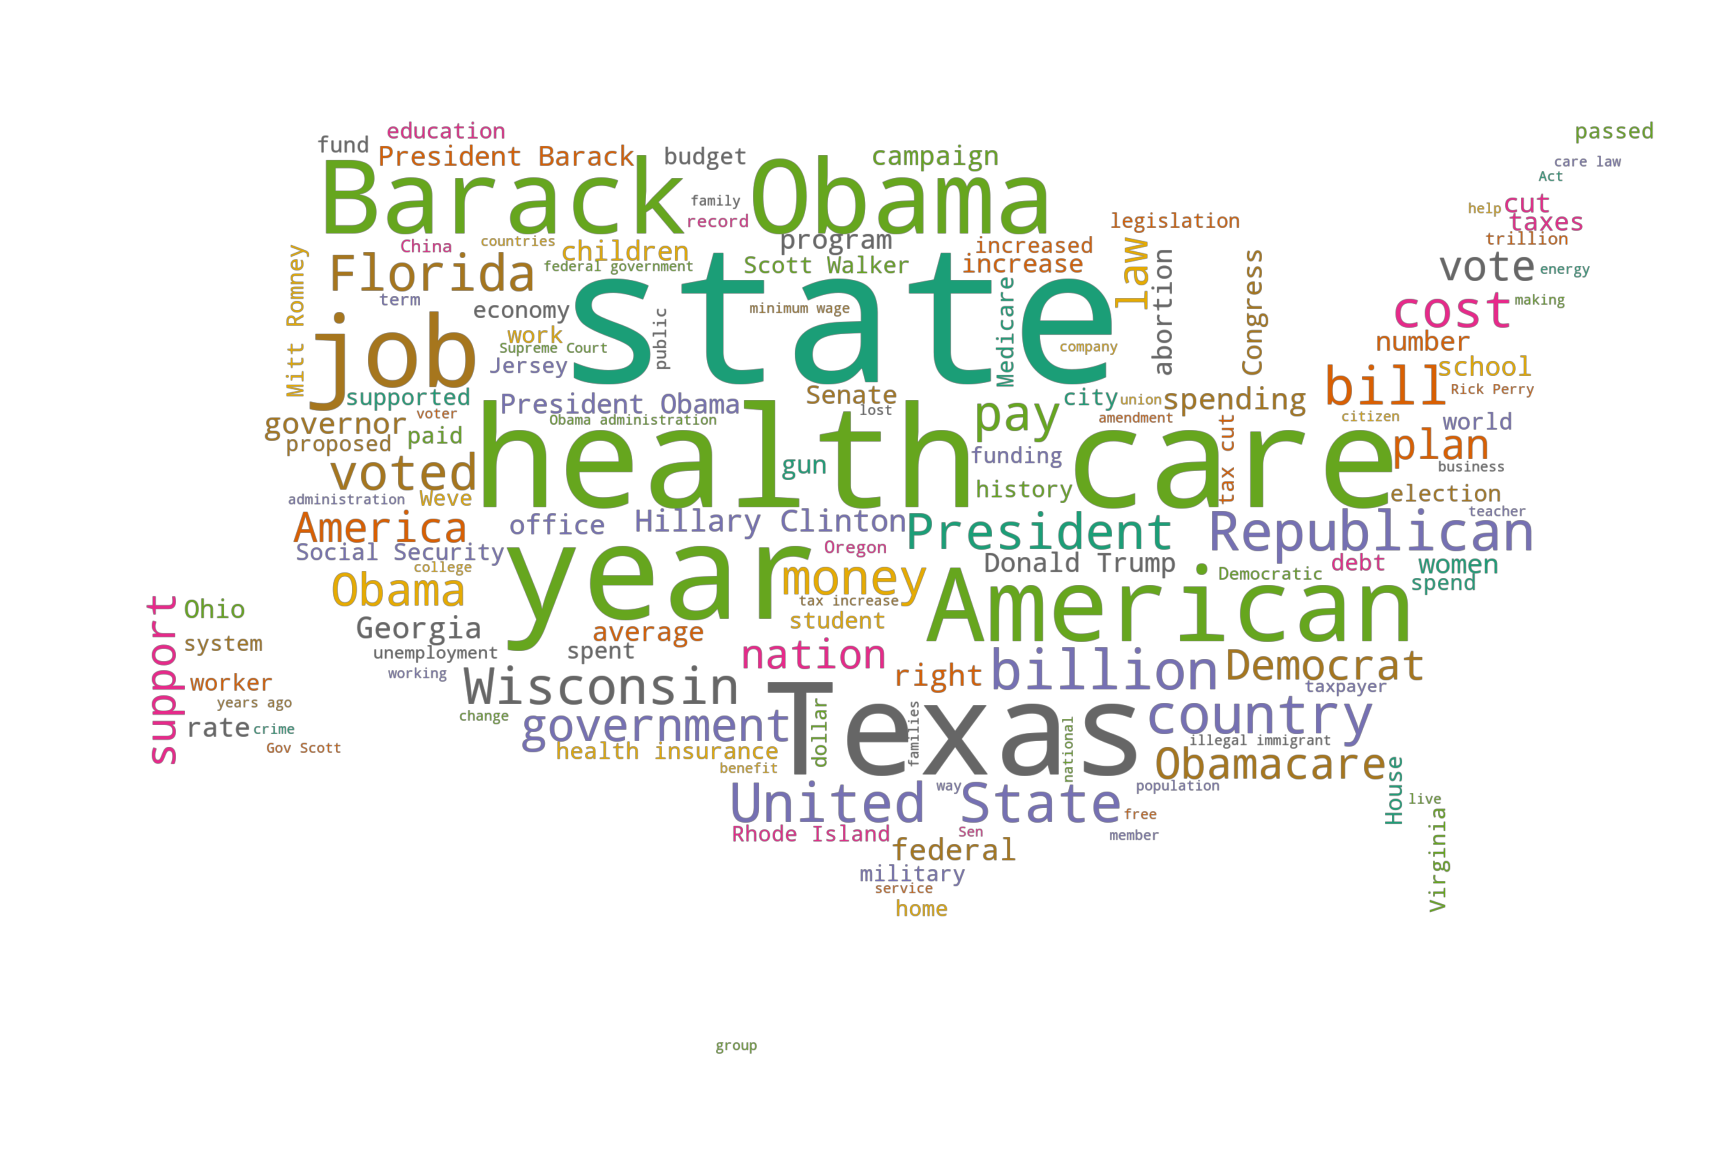

In [37]:
# Convert all the statements into a single string
text = " ".join(statement for statement in liar.statement)

# Create a list with stopwords to remove from the word cloud
stopwords = set(STOPWORDS)
stopwords.update(['Say', 'said', 'now', 'one', 'percent', 'Says', 'year', 'every',\
                  'less', 'first', 'day', 'make', 'time', 'even', 'last', 'back',\
                  'thats', 'went', 'come', 'use', 'without', 'still', 'dont', 'half',\
                  'got', 'take', 'two', 'almost', 'come', 'nearly', 'want', 'go', 'going',\
                  'new', 'made', 'third', 'used', 'month', 'never', 'many', 'three',\
                  'know', 'four', 'us', 'per', 'put', 'today', 'highest', 'give', 'Rep', \
                  'actually', 'times', 'lowest', 'single', 'already', 'top', 'think', 'including',\
                  'second', 'took', 'much', 'called', 'largest', 'show', 'didnt', 'five', 'wants', \
                  'theres', 'keep', 'higher', 'need', 'hour', 'least', 'days', 'part', 'among',\
                  'away', 'week', 'will', 'million', 'people', 'person'])

# Create a mask in the shape of the United States
usa_mask = np.array(Image.open(DATA_DIR + "usa_light_blue.png"))

# Create and generate a word cloud image
wordcloud = WordCloud(max_words = 140, stopwords = stopwords, mode = "RGBA", background_color = None,\
                      width = 800, height = 400, mask = usa_mask, contour_width = 0, contour_color = 'blue',\
                      colormap = 'Dark2').generate(text)

# Display the generated image
a = plt.figure(figsize = (30,40))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.margins(x = 0, y = 0)

plt.show()

### Venn diagram <a class="anchor" id="venn-diagram"></a>

To see if there are any differences between the subjects which either the democrats or the republicans talk about, we will create a Venn diagram showing the shared subjects and the ones which only one of the two polictical party mentions.

In order to achieve that, we first have to create a dataframe, `subject_df`, where statements with more than one subject are eploded in multiple rows. Then, the subjects for both parties will be fetched and registered in two different dataframes, `democrat_subjects` and `republican_subjects`. We will then only select the 20 most important subject for each party (with `find_top_x_republican` and `find_top_x_democrat`) and make a Venn diagram with these subjects.

In [38]:
# Drop rows with NaN in 'subject'
temp1 = liar.dropna(subset=['subject'])

# Create a dataframe where statements with more than one subject are eploded in multiple rows
subject_list = temp1['subject'].str.split(',').tolist()
subject_df = pd.DataFrame(subject_list, index=temp1['statement_id'])\
               .stack()\
               .reset_index()[['statement_id', 0]]\
               .rename(columns={0:'subject'})\
               .merge(temp1.drop('subject', axis=1), on='statement_id')\
               .filter(['statement_id', 'subject', 'label', 'party'])

In [39]:
def find_top_x_republican(col_name, x):
    '''
    Returns a list of the top x entities with the most occurencies in the column specified by col_name.
    :param col_name: str, x: int, sorted: bool
    :return: top_ten
    '''
    # Get the top x
    top_x = republican_subjects[['statement_id', col_name]].groupby(col_name)\
                                                           .count()\
                                                           .sort_values('statement_id', ascending=False)\
                                                           .head(x)\
                                                           .index\
                                                           .values\
                                                           .astype('str')
    return top_x

def find_top_x_democrat(col_name, x):
    '''
    Returns a list of the top x entities with the most occurencies in the column specified by col_name.
    :param col_name: str, x: int, sorted: bool
    :return: top_ten
    '''
    # Get the top x
    top_x = democrat_subjects[['statement_id', col_name]].groupby(col_name)\
                                                         .count()\
                                                         .sort_values('statement_id', ascending=False)\
                                                         .head(x)\
                                                         .index\
                                                         .values\
                                                         .astype('str')
    return top_x

def color_func(word, *args, **kwargs):
        '''Set the word color to blue for democrats, to red for republican and to grey for shared subjects'''
        if word in [str(elem) for elem in np.arange(20).tolist()]:
            return '#000000' # black
        elif word in [word for word in democrat_top_subjects if word not in republican_top_subjects]:
            return '#0000ff' # blue
        elif word in [word for word in republican_top_subjects if word not in democrat_top_subjects]:
            return '#ff0000' # red
        else:
            return '#808080' # gray

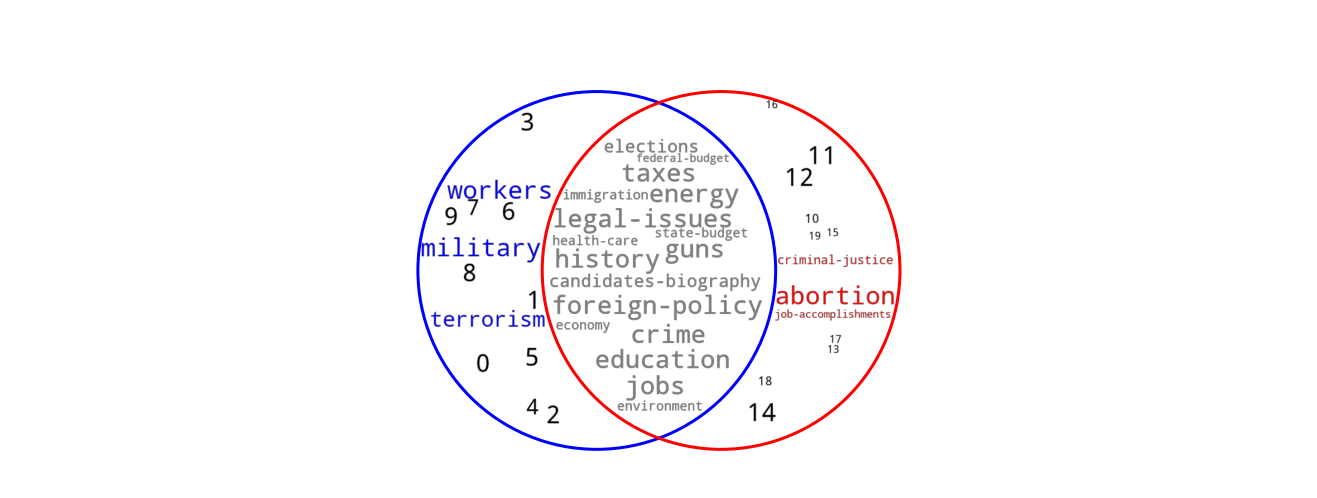

In [40]:
# Find subject addressed by democrats
democrat_subjects = subject_df.where(liar['party'] == 'democrat')\
                              .dropna()\
                              .filter(['statement_id', 'subject'])

democrat_top_subjects_unique = find_top_x_democrat('subject', 20)
democrat_filter = democrat_subjects.isin(democrat_top_subjects_unique)
democrat_top_subjects = democrat_subjects[democrat_filter['subject']]\
                                         .filter(['subject'])\
                                         .subject.tolist()

# Add "fake subjects" to improve the look of the diagram by pulling the circles appart
# (Note that this have no impact on the conclusion we can draw from the distribution of subjects)
democrat_top_subjects = democrat_top_subjects + [str(elem) for elem in np.arange(10).tolist()]

# Find subject addressed by republicans
republican_subjects = subject_df.where(liar['party'] == 'republican')\
                                .dropna()\
                                .filter(['statement_id', 'subject'])

republican_top_subjects_unique = find_top_x_republican('subject', 20)
republican_filter = republican_subjects.isin(republican_top_subjects_unique)
republican_top_subjects = republican_subjects[republican_filter['subject']]\
                                             .filter(['subject'])\
                                             .subject.tolist()

# Add "fake subjects" to improve the look of the diagram by pulling the circles appart
# (Note that this have no impact on the conclusion we can draw from the distribution of subjects)
republican_top_subjects = republican_top_subjects + [str(elem) for elem in np.arange(10,20).tolist()]

# Create the Venn diagramm
sets = []
sets.append(set(democrat_top_subjects))
sets.append(set(republican_top_subjects))
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_title("Subject adressed by democrats and republicans", fontsize=54, color='#ffffff')
venn2_wordcloud(sets,
                set_edgecolors=['b', 'r'],
                wordcloud_kwargs=dict(color_func=color_func, relative_scaling=0.99, prefer_horizontal=1),
                ax=ax)

### NetworkX <a class="anchor" id="networkx"></a>

In [41]:
# Only interested in Democrats and Republicans
node_list = liar[['speaker', 'party', 'statement', 'label']]
node_list = node_list.loc[node_list['party'].isin(['democrat', 'republican'])]
node_list.head()

speaker       party  \
0    dwayne-bohac  republican   
1  scott-surovell    democrat   
2    barack-obama    democrat   
4   charlie-crist    democrat   
5       robin-vos  republican   

                                           statement        label  
0  Says the Annies List political group supports ...        false  
1  When did the decline of coal start? It started...    half-true  
2  Hillary Clinton agrees with John McCain "by vo...  mostly-true  
4  The economic turnaround started at the end of ...    half-true  
5  The Chicago Bears have had more starting quart...         true

In [42]:
node_list = node_list.loc[node_list['label'].isin(['false', 'pants-fire'])]
node_list.head()

speaker       party  \
0           dwayne-bohac  republican   
12           mitt-romney  republican   
20     dennis-richardson  republican   
25          nancy-pelosi    democrat   
32  shelley-moore-capito  republican   

                                            statement  label  
0   Says the Annies List political group supports ...  false  
12  When Mitt Romney was governor of Massachusetts...  false  
20  Women and men both are making less when you ad...  false  
25              I dont know who (Jonathan Gruber) is.  false  
32  What (the Obama administration is) going to co...  false

In [43]:
node_list['speaker'] = node_list['speaker'].str.replace('-', ' ')
node_list.head()

speaker       party  \
0           dwayne bohac  republican   
12           mitt romney  republican   
20     dennis richardson  republican   
25          nancy pelosi    democrat   
32  shelley moore capito  republican   

                                            statement  label  
0   Says the Annies List political group supports ...  false  
12  When Mitt Romney was governor of Massachusetts...  false  
20  Women and men both are making less when you ad...  false  
25              I dont know who (Jonathan Gruber) is.  false  
32  What (the Obama administration is) going to co...  false

In [44]:
node_list['statement'] = node_list['statement'].str.lower()
node_list.head()

speaker       party  \
0           dwayne bohac  republican   
12           mitt romney  republican   
20     dennis richardson  republican   
25          nancy pelosi    democrat   
32  shelley moore capito  republican   

                                            statement  label  
0   says the annies list political group supports ...  false  
12  when mitt romney was governor of massachusetts...  false  
20  women and men both are making less when you ad...  false  
25              i dont know who (jonathan gruber) is.  false  
32  what (the obama administration is) going to co...  false

In [45]:
unique_speakers = node_list[['speaker', 'party']].drop_duplicates()
unique_speakers.reset_index(inplace=True, drop=True)
print('Number of unique speakers:', len(unique_speakers))
unique_speakers.head()

Number of unique speakers: 910


speaker       party
0          dwayne bohac  republican
1           mitt romney  republican
2     dennis richardson  republican
3          nancy pelosi    democrat
4  shelley moore capito  republican

In [46]:
node_list.iat[3,0]
unique_speakers.index[unique_speakers['speaker'] == 'nancy pelosi'].tolist()[0]

3

In [47]:
edge_list = pd.DataFrame(columns = ['Source', 'SourceID', 'Target', 'TargetID'])
for speaker in node_list['speaker']:
    index = 0
    for statement in node_list['statement']:
        if speaker in statement:
            target = speaker
            source = node_list.iat[index, 0]
            target_id = unique_speakers.index[unique_speakers['speaker'] == target].tolist()[0]
            source_id = unique_speakers.index[unique_speakers['speaker'] == source].tolist()[0]
            source_target = pd.DataFrame([[source, source_id, target, target_id]], columns=['Source', 'SourceID', 'Target', 'TargetID'])
            edge_list = edge_list.append(source_target, ignore_index = True)
        index += 1

In [48]:
edge_list.head()

Source SourceID       Target TargetID
0               mitt romney        1  mitt romney        1
1  debbie wasserman schultz       72  mitt romney        1
2          charlie gonzalez      234  mitt romney        1
3  debbie wasserman schultz       72  mitt romney        1
4            chris christie      188  mitt romney        1

In [49]:
edge_list.shape

(25872, 4)

In [50]:
net = nx.from_pandas_edgelist(edge_list, 'Source', 'Target', edge_attr = None, create_using = nx.DiGraph())
print(nx.info(net))

Name: 
Type: DiGraph
Number of nodes: 361
Number of edges: 480
Average in degree:   1.3296
Average out degree:   1.3296


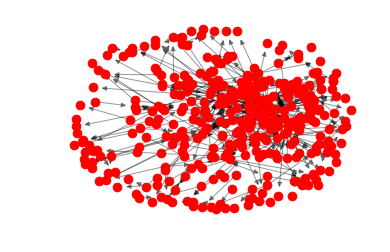

In [51]:
# plot it out
pos = nx.spring_layout(net, k=0.2)
ec = nx.draw_networkx_edges(net, pos, alpha=0.4)
nc = nx.draw_networkx_nodes(net, pos, nodelist=net.nodes(), node_color='r', cmap=plt.cm.jet, node_shape='.')
plt.axis('off')
plt.show()

In [52]:
nodes = node_list[['speaker', 'party']].drop_duplicates()
nodes.head()

speaker       party
0           dwayne bohac  republican
12           mitt romney  republican
20     dennis richardson  republican
25          nancy pelosi    democrat
32  shelley moore capito  republican

In [53]:
nodes['speaker'].is_unique

True

In [54]:
nodes = nodes.set_index('speaker')
nodes = nodes.reindex(net.nodes())

In [55]:
nodes['party'] = pd.Categorical(nodes['party'])
nodes['party'].cat.codes.head()

speaker
mitt romney                 1
debbie wasserman schultz    0
charlie gonzalez            0
chris christie              1
harry reid                  0
dtype: int8

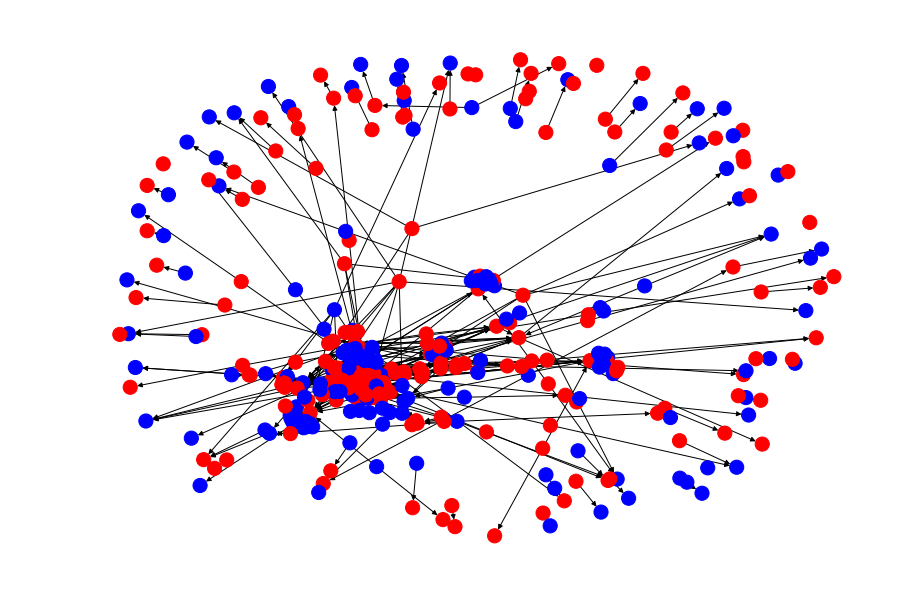

In [56]:
plt.figure(figsize=(12,8))
nx.draw(net, with_labels=False, node_color=nodes['party'].cat.codes, cmap=plt.cm.bwr, node_size=200)
plt.show()

Now we will create three graphs: a bipartite graph showing only interactions between democrats and republicans, a graph showing the interactions inside the democratic party and the last one showing the interactions inside the republican party. This will be useful to illustrate the rivalry between the two parties.

In [57]:
edges = []
edges_democrats = []
edges_republicans = []
for i in edge_list.index:
    speaker_src = edge_list['Source'][i]
    speaker_trg = edge_list['Target'][i]
    party_src = unique_speakers[unique_speakers['speaker'] == speaker_src]['party'].tolist()
    party_trg = unique_speakers[unique_speakers['speaker'] == speaker_trg]['party'].tolist()
    if party_src == party_trg:
        if party_src[0] == 'democrat':
            edges_democrats = edges_democrats + [(speaker_src, speaker_trg)]
        elif party_src[0] == 'republican':
            edges_republicans = edges_republicans + [(speaker_src, speaker_trg)]
    else:
        edges = edges + [(speaker_src, speaker_trg)]

# Find all speakers for both parties
unique_democrats = unique_speakers.where(unique_speakers['party']=='democrat')['speaker'].dropna().tolist()
unique_republicans = unique_speakers.where(unique_speakers['party']=='republican')['speaker'].dropna().tolist()

# Define the node color (blue for democrats and red for republicans)
node_color = np.asarray(len(unique_democrats)*[0] + len(unique_republicans)*[1])

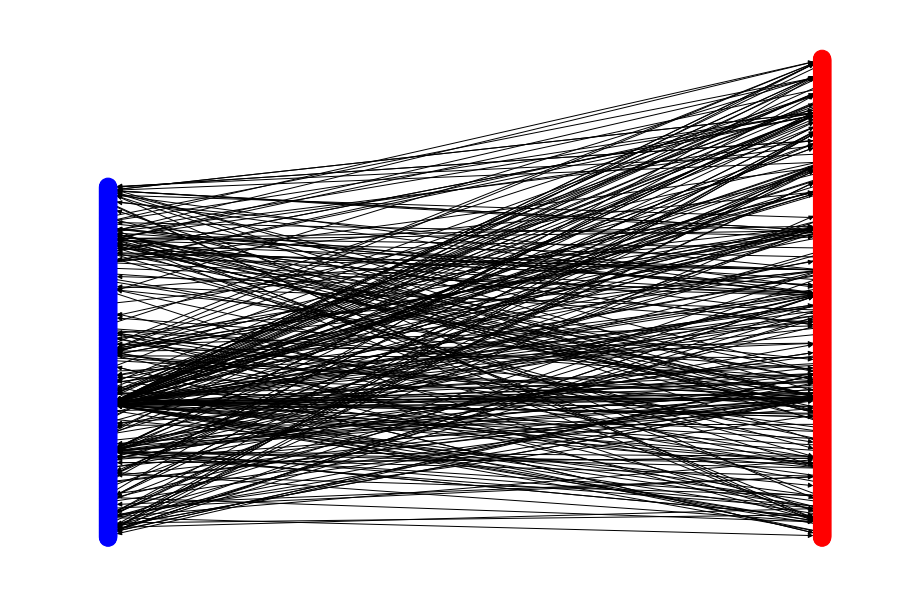

In [58]:
unique_democrats = unique_speakers.where(unique_speakers['party']=='democrat')['speaker'].dropna().tolist()
unique_republicans = unique_speakers.where(unique_speakers['party']=='republican')['speaker'].dropna().tolist()

DR = nx.DiGraph()

# Add nodes with the node attribute "bipartite"
DR.add_nodes_from(unique_democrats, bipartite=0)
DR.add_nodes_from(unique_republicans, bipartite=1)

# Add edges only between nodes of opposite node sets
DR.add_edges_from(edges)

# Define a different location for nodes of republicans and democrats
top_nodes = {n for n, d in DR.nodes(data=True) if d['bipartite']==0}
bottom_nodes = set(DR) - top_nodes
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(top_nodes) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(bottom_nodes) ) # put nodes from Y at x=2

# Plot the graph
fig_DR = plt.figure(figsize=(12,8))
nx.draw(DR, pos=pos, node_color=node_color, cmap=plt.cm.bwr)

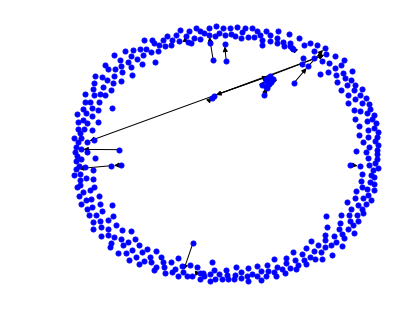

In [59]:
D = nx.DiGraph()

# Add nodes with the node attribute "bipartite"
D.add_nodes_from(unique_democrats)

# Add edges only between nodes of opposite node sets
D.add_edges_from(edges_democrats)

# Plot the graph
fig_D = plt.figure(figsize=(5,4))
nx.draw(D, node_color='blue', node_size = 25)

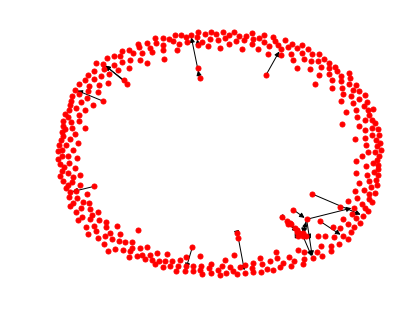

In [60]:
R = nx.DiGraph()

# Add nodes with the node attribute "bipartite"
R.add_nodes_from(unique_democrats)

# Add edges only between nodes of opposite node sets
R.add_edges_from(edges_democrats)

# Plot the graph
fig_R = plt.figure(figsize=(5,4))
nx.draw(R, node_size = 25)

### HoloViews Circle <a class="anchor" id="holoviews"></a>

We want to take a closer look at the 20 Democrats/Republicans with the most 'pants-fire' and 'false' statements; to visualize the amount of lies, and the relationships between the politicians in a graph. To do so, we use a `Chord` element in HoloViews.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
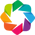

In [61]:
hv.extension('bokeh')

In [62]:
# Only interested in Democrats and Republicans
statements = liar[['speaker', 'party', 'statement', 'label']]
statements = statements.loc[statements['party'].isin(['democrat', 'republican'])]
statements.head()

speaker       party  \
0    dwayne-bohac  republican   
1  scott-surovell    democrat   
2    barack-obama    democrat   
4   charlie-crist    democrat   
5       robin-vos  republican   

                                           statement        label  
0  Says the Annies List political group supports ...        false  
1  When did the decline of coal start? It started...    half-true  
2  Hillary Clinton agrees with John McCain "by vo...  mostly-true  
4  The economic turnaround started at the end of ...    half-true  
5  The Chicago Bears have had more starting quart...         true

In [63]:
statements['speaker'] = statements['speaker'].str.replace('-', ' ')
statements['statement'] = statements['statement'].str.lower()
statements.head()

speaker       party  \
0    dwayne bohac  republican   
1  scott surovell    democrat   
2    barack obama    democrat   
4   charlie crist    democrat   
5       robin vos  republican   

                                           statement        label  
0  says the annies list political group supports ...        false  
1  when did the decline of coal start? it started...    half-true  
2  hillary clinton agrees with john mccain "by vo...  mostly-true  
4  the economic turnaround started at the end of ...    half-true  
5  the chicago bears have had more starting quart...         true

In [64]:
node_list = statements[['speaker', 'party']].drop_duplicates()
node_list.head()

speaker       party
0    dwayne bohac  republican
1  scott surovell    democrat
2    barack obama    democrat
4   charlie crist    democrat
5       robin vos  republican

In [65]:
# Check that each speaker is affiliated with only one party
node_list['speaker'].is_unique

True

In [66]:
edge_list['Count'] = 1
edge_list.head()

Source SourceID       Target TargetID  Count
0               mitt romney        1  mitt romney        1      1
1  debbie wasserman schultz       72  mitt romney        1      1
2          charlie gonzalez      234  mitt romney        1      1
3  debbie wasserman schultz       72  mitt romney        1      1
4            chris christie      188  mitt romney        1      1

In [67]:
# Count the lies between speakers
edge_count = edge_list.groupby(['Source', 'Target']).Count.count().reset_index()
nodes = hv.Dataset(node_list, 'speaker', 'party')
chord = hv.Chord((edge_count, nodes), ['Source', 'Target'], ['Count'])

# Select the top 20 liars
top_20 = list(edge_list.groupby('Source').count().sort_values('Count').iloc[-20:].index.values)
top_20_liars = chord.select(speaker=top_20, selection_mode='nodes')

In [68]:
edge_count.head()

Source          Target  Count
0   adam kinzinger       rand paul     11
1     alan grayson    alan grayson      6
2     alan grayson  patrick murphy      1
3     alan grayson        ted cruz     42
4  alberta darling     sandy pasch      1

In [69]:
%%opts Chord [edge_color_index='Source' label_index='speaker' color_index='Target' width=800 height=800]
%%opts Chord (cmap='Category20' edge_cmap='Category20')
top_20_liars

:Chord   [Source,Target]   (Count)

### Sentiment Analysis <a class="anchor" id="sentiment"></a>

We first wanted to see if there were any differences between truths and lies with regard to sentiment; e.g., would lies turn out be more negative, and truths more positive. Or perhaps the other way around? We used Spacy and a sentiment analyzer to explore this, but quickly observed that there were approximately the same number of positve and negative statements for both truths and lies, and more neutral statements in both cases. This was not a very interesting obersvation, but a little surprising, as we would expect political statements to have a somewhat strong sentiment, either positive or negative.

Since our first analysis didn't give any results of importance, we then analyzed the sentiment of the statements made by Democrats and Republicans, respectively. Sadly, this analysis yielded approximately the same (uninteresting) results, and so we decided to try a more narrow approach; to analyze the sentiment of a few isolated subjects with respect to Democrats and Republicans. More specifically; health care and immigration. Neither yielded particularly interesting results, and so we're choosing to leave the sentiment analysis out of the data story, altogether. However, we leave the code here, with the health care approach, as an example.

We first extract only the statements discussing health-care made by Democrats, and then by Republicans.

In [70]:
statements = liar[['statement', 'party', 'subject']]
health_care = statements.loc[statements['subject'].isin(['health-care'])]

democrats = health_care.loc[health_care['party'].isin(['democrat'])]
republicans = health_care.loc[health_care['party'].isin(['republican'])]

print('Statements on health care by democrats:', len(democrats))
print('Statements on health care by republicans:', len(republicans))

Statements on health care by democrats: 171
Statements on health care by republicans: 232


We then turn the DataFrames into a corpus and a document for natural language processing. 

In [71]:
corpus_democrats = ' '.join(democrats['statement'])
corpus_democrats[0:600]

'I dont know who (Jonathan Gruber) is. In Rick Perrys Texas, we import nurses ... from other countries. We now have driven (health care) costs down to the lowest theyve been in 50 years. Most young Americans right now, theyre not covered by health insurance. Says Congressman Bill Pascrell voted to remove the public option from the Affordable Health Care Act. What we said was, you can keep (your plan) if it hasnt changed since the law passed. 14,000 Americans . . . lose their health insurance every single day. The Affordable Care Act is bringing the cost of health care in our country down. David'

In [72]:
corpus_republicans = ' '.join(republicans['statement'])
corpus_republicans[0:600]

'The insurance commissioner cant do squat about health care. Says Rick Perry wrote a letter supporting Hillarycare. The American people support defunding Obamacare and oppose shutting down the government. Jason Carter supports using Georgia tax dollars to promote Obamacare New federal projections estimate that the health care overhaul will cost $1.76 trillion over 10 years -- well above the $940 billion Democrats originally claimed. Charlie Crist has six different positions on ObamaCare. We spend more money on health care per capita in the United States than any other country in the world. Of t'

In [73]:
nlp = spacy.load('en')

democrats_doc = nlp(corpus_democrats)

republicans_doc = nlp(corpus_republicans)

In [74]:
# Initialize the analyser
analyzer = SentimentIntensityAnalyzer()

#### Sentiment Analysis of Health Care by Democrats <a class="anchor" id="sentiment-democrat"></a>
For the sentiment analysis, we iterate through all the sentences, get a polarity score, and visualize with a histogram.

We start by analyzing the statements made by Democrats.

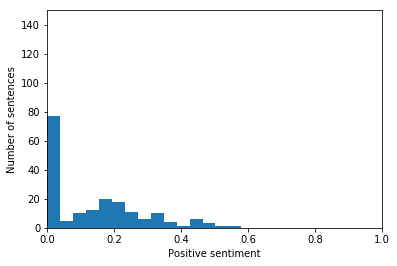

In [75]:
# Show the positive sentiment of the Democrats
positive_sent = []
[positive_sent.append(analyzer.polarity_scores(sent.text)['pos']) for sent in democrats_doc.sents]
plt.hist(positive_sent, bins=15)
plt.xlim([0, 1])
plt.ylim([0, 150])
plt.xlabel('Positive sentiment')
plt.ylabel('Number of sentences')
plt.show()

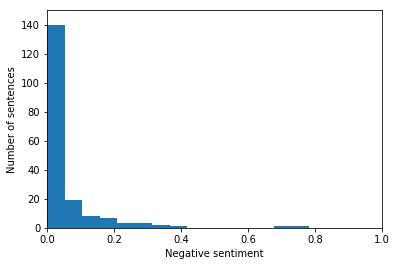

In [76]:
# Show the negative sentiment of the Democrats
negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent.text)['neg']) for sent in democrats_doc.sents]
plt.hist(negative_sent, bins=15)
plt.xlim([0, 1])
plt.ylim([0, 150])
plt.xlabel('Negative sentiment')
plt.ylabel('Number of sentences')
plt.show()

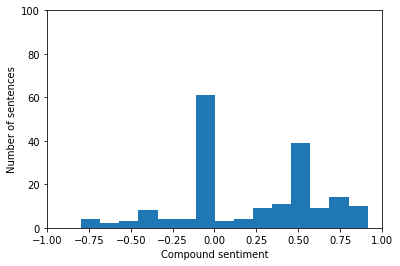

In [77]:
# Show the comound sentiment for the Democrats
total_sent = []
[total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in democrats_doc.sents]
plt.hist(total_sent, bins=15)
plt.xlim([-1, 1])
plt.ylim([0, 100])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of sentences')
plt.show()

In [78]:
# Get the number of sentences for each sentiment
sents = [analyzer.polarity_scores(sent.text)['compound'] for sent in democrats_doc.sents]
print('Number of positive sentences:', sum(np.array(sents)>=0.05))
print('Number of negative sentences:', sum(np.array(sents)<=-0.05))
print('Number of neutral sentences:', sum(np.abs(np.array(sents))<0.05))

Number of positive sentences: 98
Number of negative sentences: 28
Number of neutral sentences: 59


#### Sentiment Analysis of Health Care by Republicans  <a class="anchor" id="sentiment-republican"></a>

We repeat the process for the Republicans.

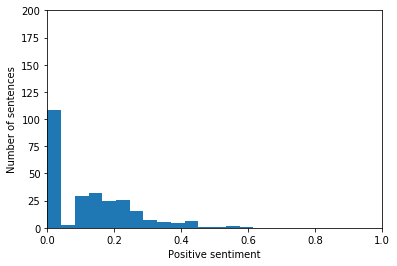

In [79]:
# Show the positive sentiment for the Republicans
positive_sent = []
[positive_sent.append(analyzer.polarity_scores(sent.text)['pos']) for sent in republicans_doc.sents]
plt.hist(positive_sent, bins=15)
plt.xlim([0, 1])
plt.ylim([0, 200])
plt.xlabel('Positive sentiment')
plt.ylabel('Number of sentences')
plt.show()

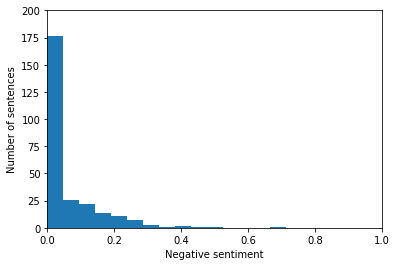

In [80]:
# Show the negative sentiment for the Republicans
negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent.text)['neg']) for sent in republicans_doc.sents]
plt.hist(negative_sent, bins=15)
plt.xlim([0, 1])
plt.ylim([0, 200])
plt.xlabel('Negative sentiment')
plt.ylabel('Number of sentences')
plt.show()

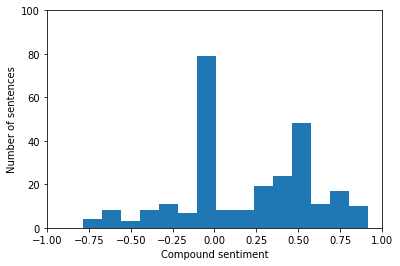

In [81]:
# Show the compound sentiment for the truths
total_sent = []
[total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in republicans_doc.sents]
plt.hist(total_sent, bins=15)
plt.xlim([-1, 1])
plt.ylim([0, 100])
plt.xlabel('Compound sentiment')
plt.ylabel('Number of sentences')
plt.show()

In [82]:
# Get the number of sentences for each sentiment
sents = [analyzer.polarity_scores(sent.text)['compound'] for sent in republicans_doc.sents]
print('Number of positive sentences:', sum(np.array(sents)>=0.05))
print('Number of negative sentences:', sum(np.array(sents)<=-0.05))
print('Number of neutral sentences:', sum(np.abs(np.array(sents))<0.05))

Number of positive sentences: 142
Number of negative sentences: 46
Number of neutral sentences: 77


We make some observations with regard to Democrats' and Republicans' discussion of health care. The pattern is the same for both parties; most sentences are positive, quite a few are neutral, and negative sentences are most rare. This surprised us a little, as these statements are from the time of Obama Care, and we would expect the Republicans to be more negative. However, we still don't find it interesting enough for it to be a part of the data story. 